# Heading 01

In [1]:
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

from tqdm import tqdm

from functools import partial
import scipy as sp

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px

from sklearn.tree import plot_tree
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import roc_curve, RocCurveDisplay, cohen_kappa_score
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier, XGBRegressor

In [4]:
%matplotlib inline

In [ ]:
train = pd.read_csv(r'I:/Downloads/playground-series-s3e5/train.csv')
test = pd.read_csv(r'I:/Downloads/playground-series-s3e5/test.csv')
submission = pd.read_csv(r'I:/Downloads/playground-series-s3e5/sample_submission.csv')

In [ ]:
print('shape of the train dataset: ', train.shape)
print('shape of the test dataset: ', test.shape)

shape of the train dataset:  (2056, 13)
shape of the test dataset:  (1372, 12)


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2056 entries, 0 to 2055
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Id                    2056 non-null   int64  
 1   fixed acidity         2056 non-null   float64
 2   volatile acidity      2056 non-null   float64
 3   citric acid           2056 non-null   float64
 4   residual sugar        2056 non-null   float64
 5   chlorides             2056 non-null   float64
 6   free sulfur dioxide   2056 non-null   float64
 7   total sulfur dioxide  2056 non-null   float64
 8   density               2056 non-null   float64
 9   pH                    2056 non-null   float64
 10  sulphates             2056 non-null   float64
 11  alcohol               2056 non-null   float64
 12  quality               2056 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 208.9 KB


In [ ]:
train.head()

,Id,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0,8.0,0.50,0.39,2.2,0.073,30.0,39.0,0.99572,3.33,0.77,12.1,6
1,1,9.3,0.30,0.73,2.3,0.092,30.0,67.0,0.99854,3.32,0.67,12.8,6
2,2,7.1,0.51,0.03,2.1,0.059,3.0,12.0,0.99660,3.52,0.73,11.3,7
3,3,8.1,0.87,0.22,2.6,0.084,11.0,65.0,0.99730,3.20,0.53,9.8,5
4,4,8.5,0.36,0.30,2.3,0.079,10.0,45.0,0.99444,3.20,1.36,9.5,6


In [ ]:
train.tail()

,Id,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
2051,2051,6.6,0.31,0.13,2.00,0.056,29.0,42.0,0.99388,3.52,0.87,12.0,7
2052,2052,9.7,0.59,0.21,1.80,0.079,27.0,65.0,0.99745,3.14,0.58,9.4,5
2053,2053,7.7,0.43,0.42,1.70,0.071,19.0,37.0,0.99258,3.32,0.77,12.5,8
2054,2054,9.1,0.50,0.00,1.75,0.058,5.0,13.0,0.99670,3.22,0.42,9.5,5
2055,2055,6.2,0.31,0.18,2.30,0.059,12.0,28.0,0.99520,3.56,0.88,11.4,7


In [ ]:
train.isna().any()

Id                      False
fixed acidity           False
volatile acidity        False
citric acid             False
residual sugar          False
chlorides               False
free sulfur dioxide     False
total sulfur dioxide    False
density                 False
pH                      False
sulphates               False
alcohol                 False
quality                 False
dtype: bool

In [3]:
print("Null values: \nTrain:", train.isnull().sum().sum(), "\nTest:",train.isnull().sum().sum())

NameError: ignored

In [ ]:
train.quality.unique()

array([6, 7, 5, 4, 8, 3], dtype=int64)

In [ ]:
TARGET = "quality"

In [ ]:
test.describe()

,Id,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,2741.500000,8.369606,0.524311,0.270569,2.415926,0.081307,17.162536,49.089286,0.996670,3.312223,0.647267,10.473081
std,396.206596,1.664694,0.176942,0.185731,0.921155,0.026566,9.974082,32.803721,0.001822,0.141405,0.134792,1.027170
min,2056.000000,4.900000,0.120000,0.000000,1.300000,0.012000,1.000000,8.000000,0.990070,2.740000,0.390000,8.800000
25%,2398.750000,7.100000,0.390000,0.110000,2.000000,0.070000,8.000000,23.000000,0.995380,3.210000,0.550000,9.600000
50%,2741.500000,7.900000,0.500000,0.260000,2.200000,0.078000,16.000000,43.000000,0.996600,3.310000,0.620000,10.200000
75%,3084.250000,9.100000,0.635000,0.420000,2.500000,0.087000,24.000000,66.000000,0.997800,3.390000,0.730000,11.200000
max,3427.000000,15.600000,1.330000,0.760000,8.300000,0.467000,68.000000,165.000000,1.003200,4.010000,1.620000,14.000000


In [ ]:
test.head()

,Id,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,2056,7.2,0.510,0.01,2.0,0.077,31.0,54.0,0.99748,3.39,0.59,9.8
1,2057,7.2,0.755,0.15,2.0,0.102,14.0,35.0,0.99586,3.33,0.68,10.0
2,2058,8.4,0.460,0.40,2.0,0.065,21.0,50.0,0.99774,3.08,0.65,9.5
3,2059,8.0,0.470,0.40,1.8,0.056,14.0,25.0,0.99480,3.30,0.65,11.7
4,2060,6.5,0.340,0.32,2.1,0.044,8.0,94.0,0.99356,3.23,0.48,12.8


In [ ]:
 train['quality'].value_counts()

5    839
6    778
7    333
4     55
8     39
3     12
Name: quality, dtype: int64

In [ ]:
round(100 * train['quality'].value_counts() / train.shape[0], 2)

5    40.81
6    37.84
7    16.20
4     2.68
8     1.90
3     0.58
Name: quality, dtype: float64

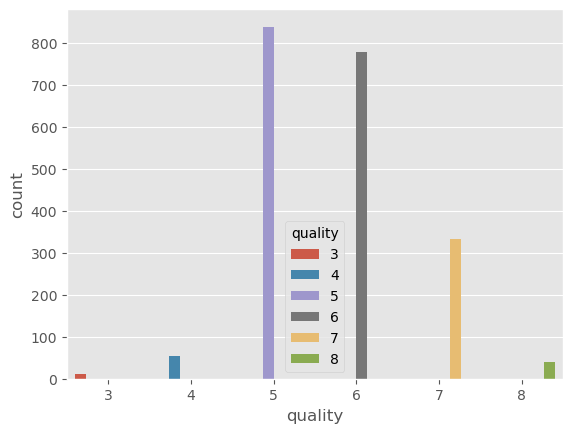

In [ ]:
sns.countplot(x = 'quality', hue = 'quality', data = train);

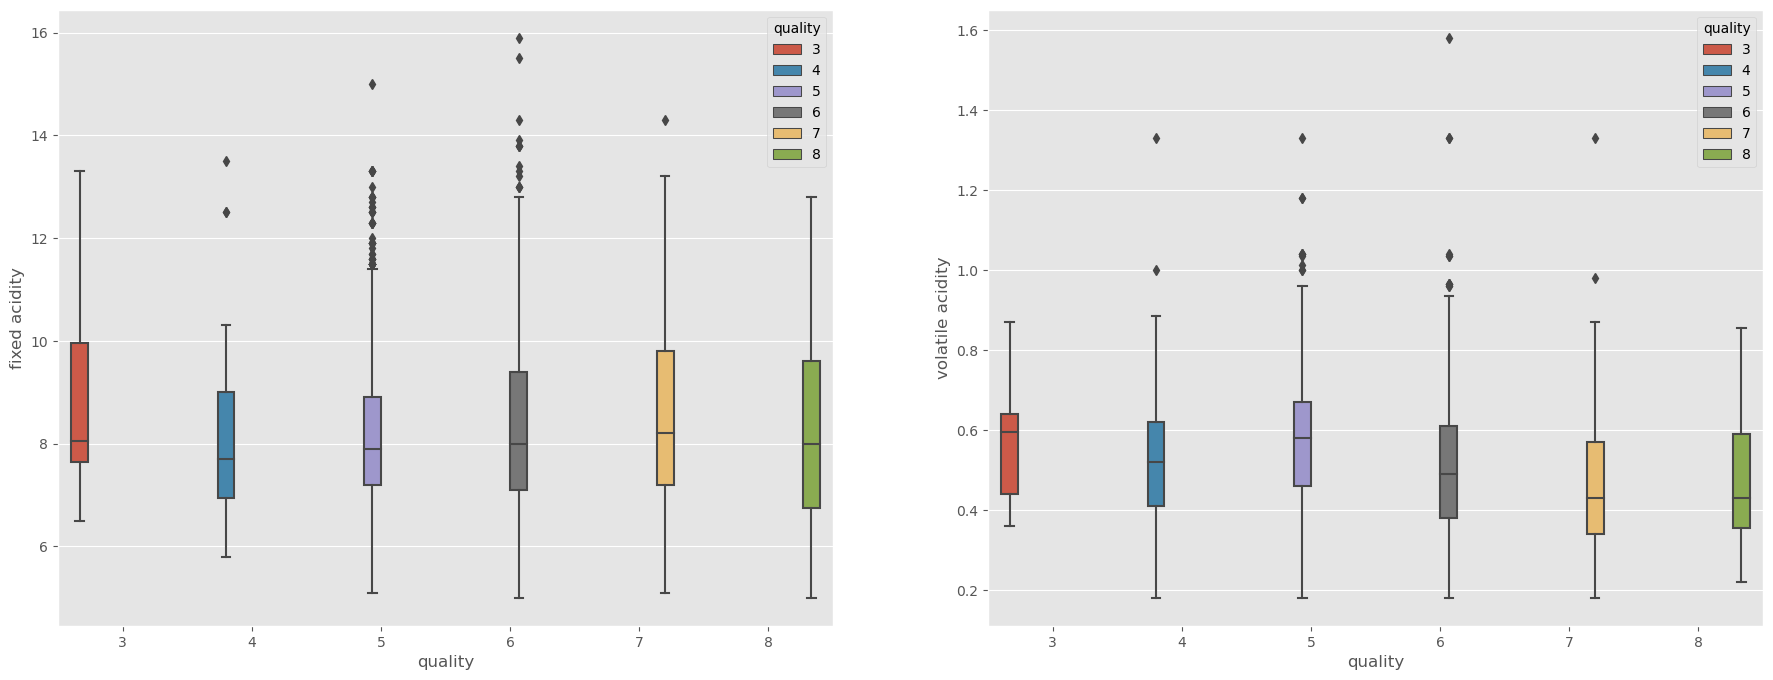

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (22, 8))

sns.boxplot(ax = axes[0], x = 'quality', y = 'fixed acidity', hue = 'quality', data = train)
sns.boxplot(ax = axes[1], x = 'quality', y = 'volatile acidity', hue = 'quality', data = train);

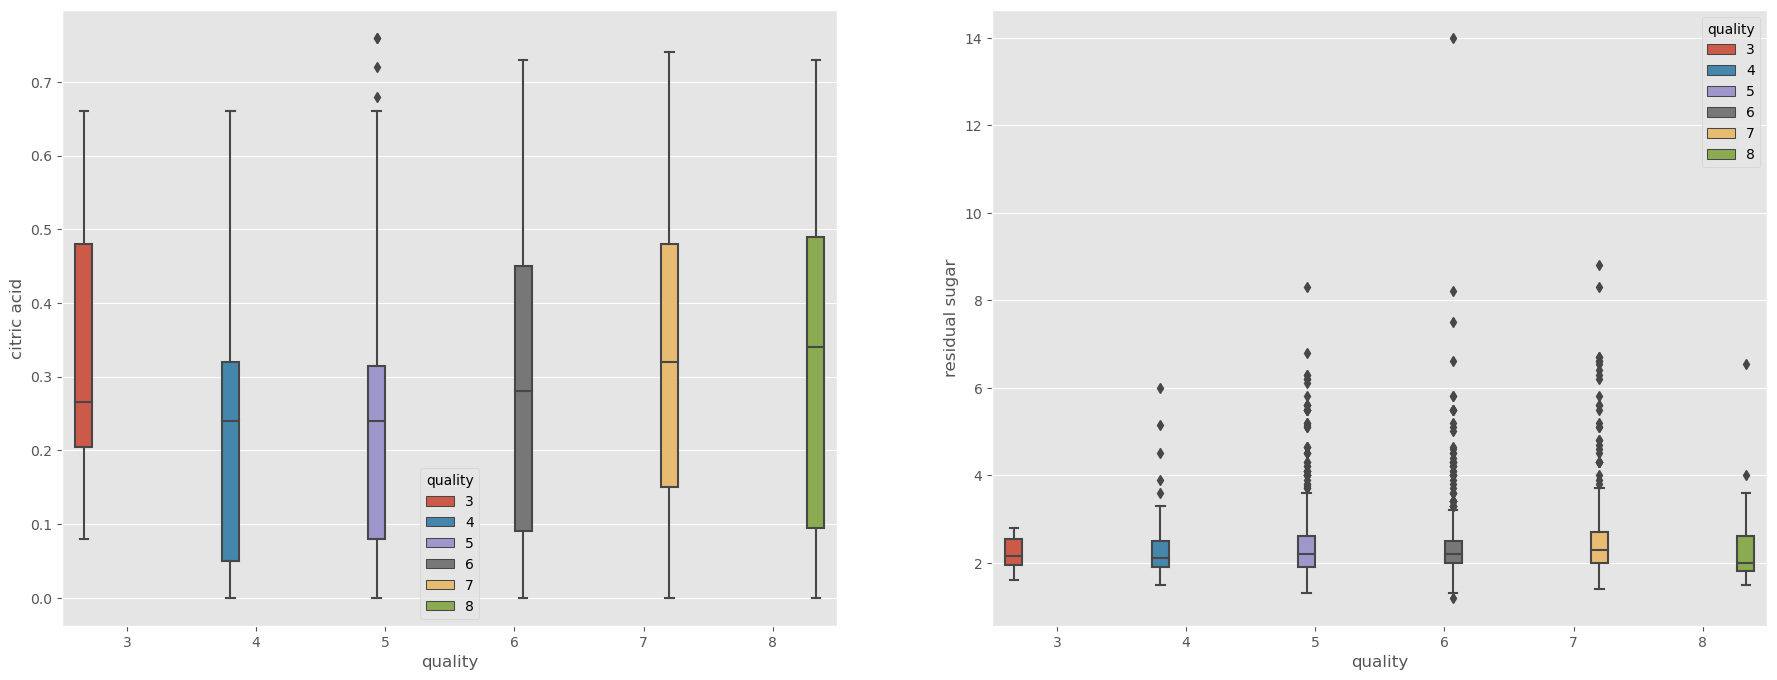

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (22, 8))

sns.boxplot(ax = axes[0], x = 'quality', y = 'citric acid', hue = 'quality', data = train)
sns.boxplot(ax = axes[1], x = 'quality', y = 'residual sugar', hue = 'quality', data = train);

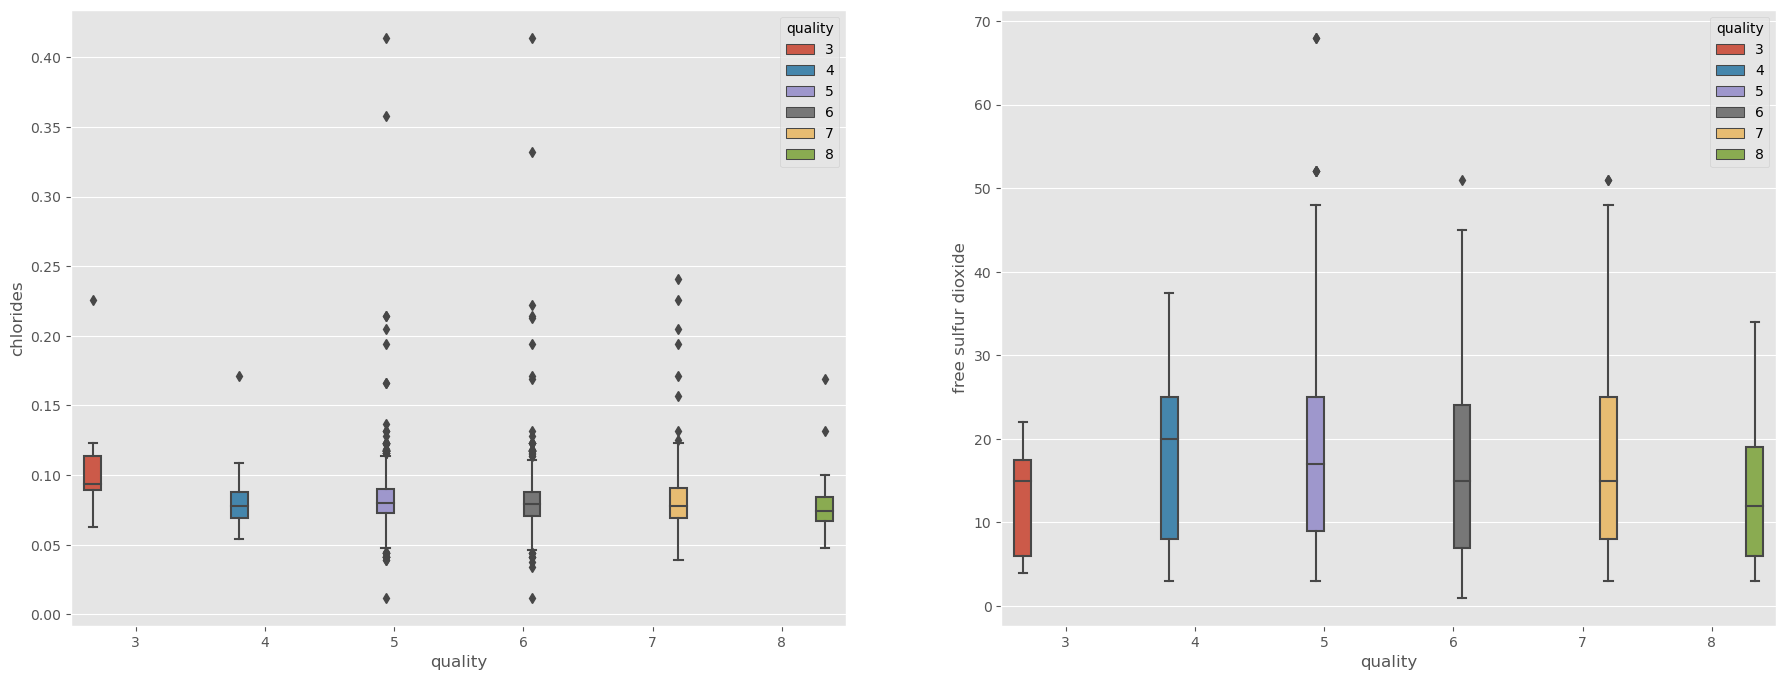

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (22, 8))

sns.boxplot(ax = axes[0], x = 'quality', y = 'chlorides', hue = 'quality', data = train)
sns.boxplot(ax = axes[1], x = 'quality', y = 'free sulfur dioxide', hue = 'quality', data = train);


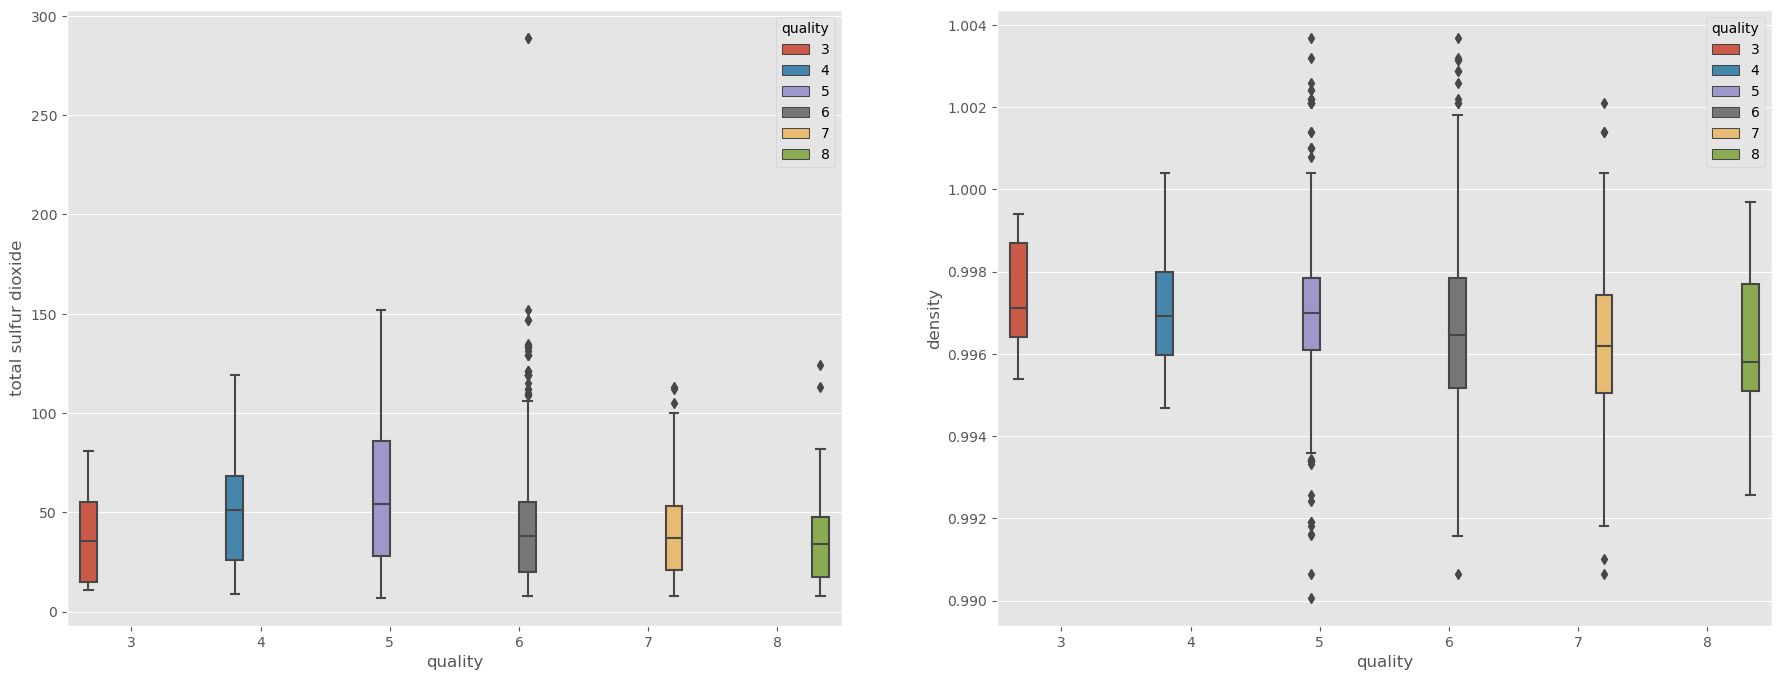

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (22, 8))

sns.boxplot(ax = axes[0], x = 'quality', y = 'total sulfur dioxide', hue = 'quality', data = train)
sns.boxplot(ax = axes[1], x = 'quality', y = 'density', hue = 'quality', data = train);

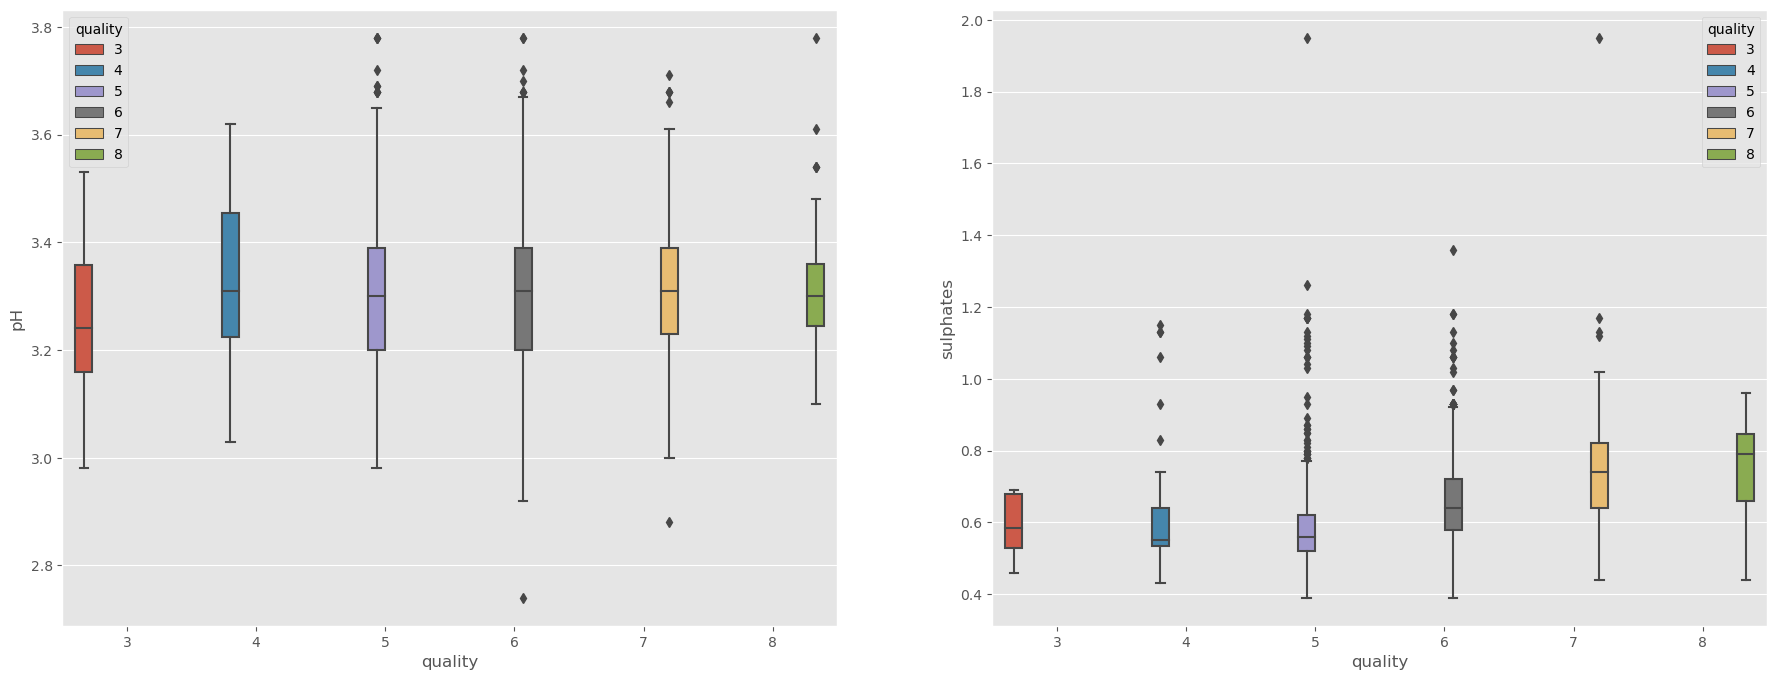

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (22, 8))

sns.boxplot(ax = axes[0], x = 'quality', y = 'pH', hue = 'quality', data = train)
sns.boxplot(ax = axes[1], x = 'quality', y = 'sulphates', hue = 'quality', data = train);

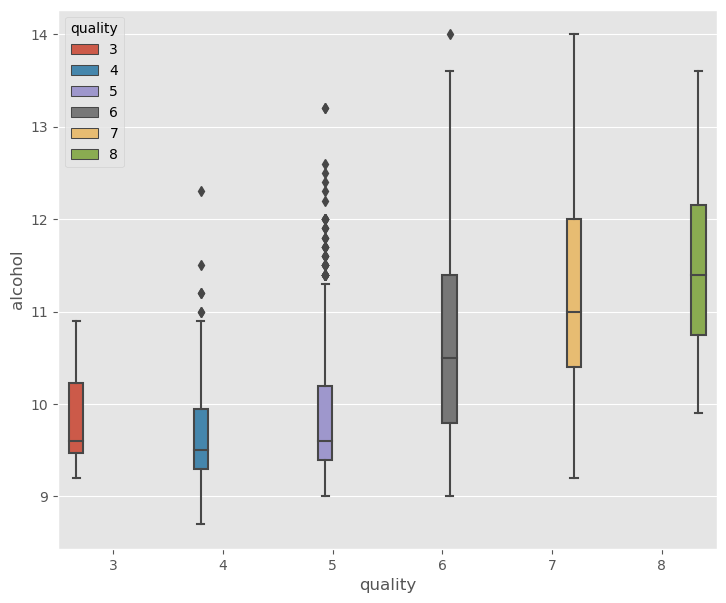

In [ ]:
plt.figure(figsize = (8.5, 7))
sns.boxplot(x = 'quality', y = 'alcohol', hue = 'quality', data = train);

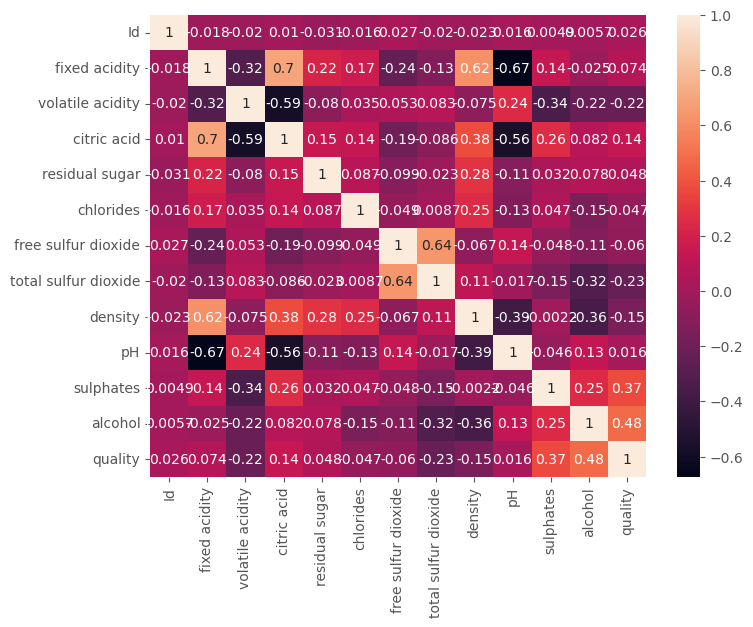

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
matrix = train.corr()
sns.heatmap(matrix, annot=True)
plt.show()

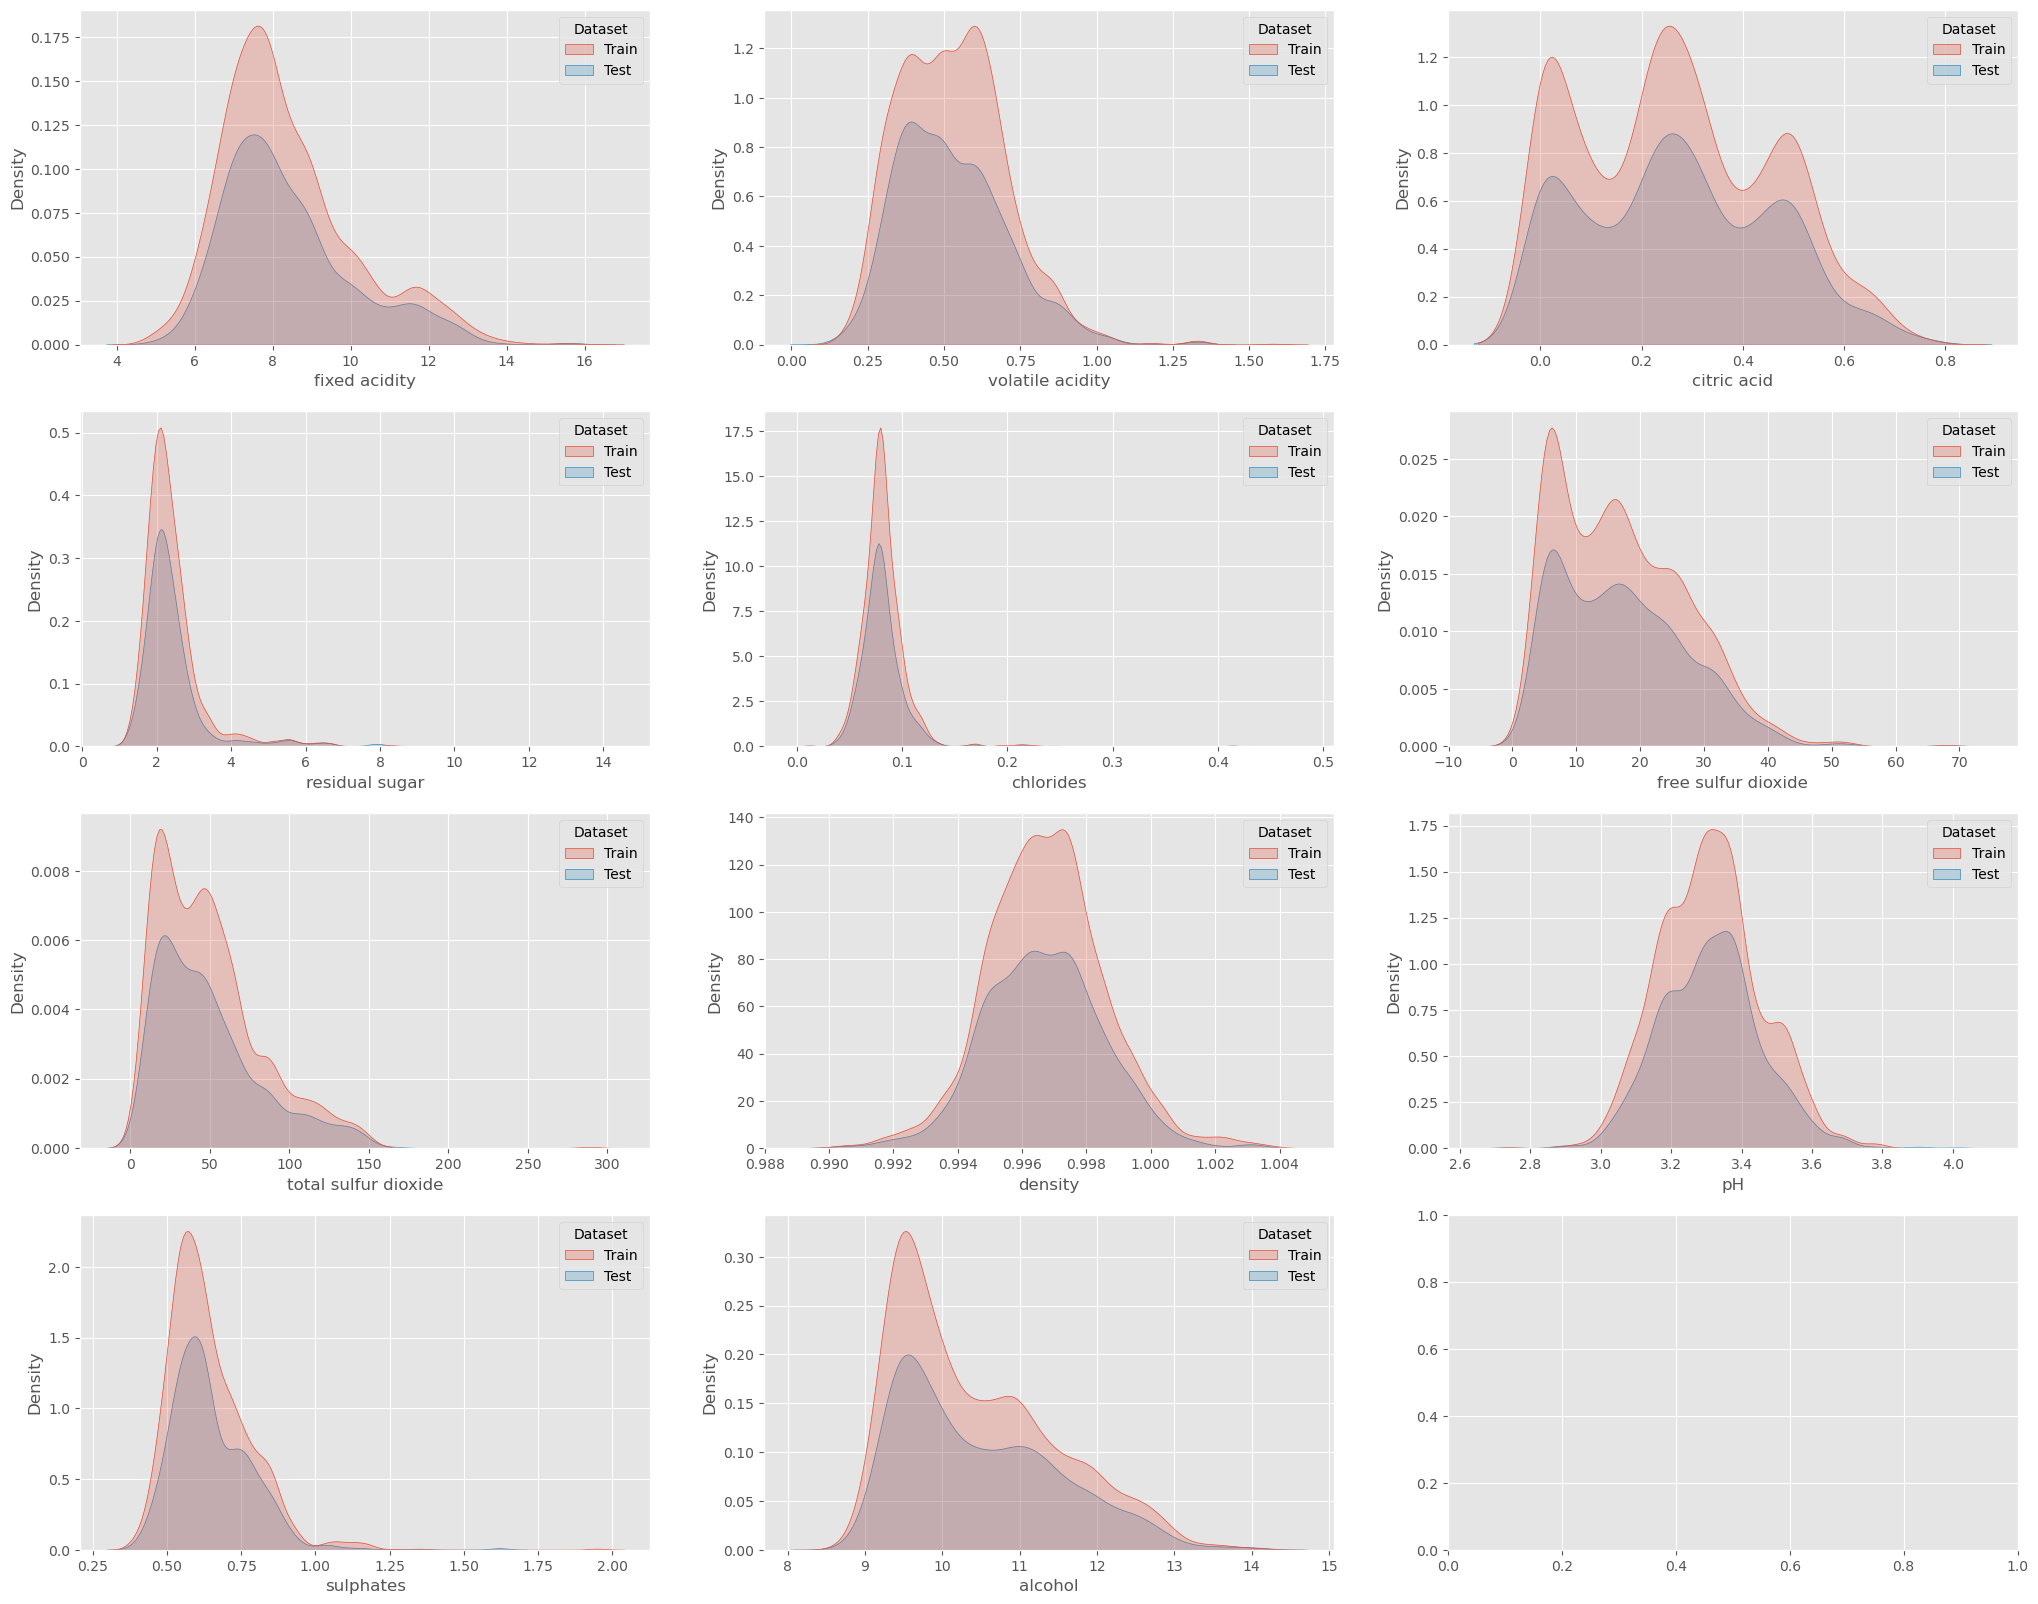

In [ ]:
train_vis = train.drop(columns = 'quality', axis = 1).reset_index(drop = True).copy()
test_vis = test.copy()

train_vis['Dataset'] = 'Train'
test_vis['Dataset'] = 'Test'
data_tot = pd.concat([train_vis, test_vis], axis = 0).reset_index(drop = True)

fig, axes = plt.subplots(4, 3, figsize = (25, 20))

sns.kdeplot(ax = axes[0, 0], x = 'fixed acidity', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[0, 1], x = 'volatile acidity', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[0, 2], x = 'citric acid', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[1, 0], x = 'residual sugar', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[1, 1], x = 'chlorides', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[1, 2], x = 'free sulfur dioxide', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[2, 0], x = 'total sulfur dioxide', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[2, 1], x = 'density', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[2, 2], x = 'pH', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[3, 0], x = 'sulphates', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[3, 1], x = 'alcohol', hue = 'Dataset', data = data_tot, fill = True);

In [ ]:
test_md = test.copy()

X = train.drop(columns = ['Id', 'quality'], axis = 1)
Y = train['quality']
test_md = test_md.drop(columns = 'Id', axis = 1)

XGB_cv_scores, XGB_imp = list(), list()
preds = list()

## Running 5 times CV
for i in range(5):

    skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)

    for train_ix, test_ix in skf.split(X, Y):

        ## Splitting the data
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]

        ## Building RF model
        XGB_md = XGBClassifier(tree_method = 'gpu_hist',
                               colsample_bytree = 0.7,
                               gamma = 0.8,
                               learning_rate = 0.01,
                               max_depth = 5,
                               min_child_weight = 10,
                               n_estimators = 1000,
                               subsample = 0.7)

        One_vs_Rest_XGB = OneVsRestClassifier(estimator = XGB_md).fit(X_train, Y_train)

        ## Predicting on X_test and test
        XGB_pred_1 = One_vs_Rest_XGB.predict(X_test)
        XGB_pred_2 = One_vs_Rest_XGB.predict(test_md)

        ## Computing roc-auc score
        XGB_cv_scores.append(cohen_kappa_score(Y_test, XGB_pred_1, weights = 'quadratic'))
        preds.append(XGB_pred_2)

XGB_cv_score = np.mean(XGB_cv_scores)
print('The average oof quadratic weighted kapp score over 5-folds (run 5 times) is:', XGB_cv_score)

The average oof quadratic weighted kapp score over 5-folds (run 5 times) is: 0.4884673587136205


In [ ]:
X_test

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
6,7.2,0.87,0.00,2.3,0.080,6.0,18.0,0.99552,3.34,0.60,11.3
11,10.4,0.24,0.42,2.4,0.059,6.0,15.0,0.99720,3.08,0.86,10.8
26,7.3,0.70,0.00,2.2,0.058,16.0,42.0,0.99472,3.38,0.60,11.8
28,8.9,0.56,0.18,1.9,0.074,12.0,46.0,0.99690,3.17,0.92,9.5
29,10.8,0.50,0.55,2.2,0.077,15.0,33.0,0.99880,3.18,0.60,9.4
...,...,...,...,...,...,...,...,...,...,...,...
2037,5.6,0.54,0.19,1.9,0.062,30.0,69.0,0.99344,3.56,0.61,10.3
2038,10.4,0.32,0.43,2.4,0.061,25.0,42.0,0.99840,3.08,0.81,10.0
2043,7.7,0.63,0.27,1.8,0.097,20.0,84.0,0.99586,3.16,0.49,9.5
2046,8.0,0.87,0.29,2.6,0.084,12.0,44.0,0.99790,3.30,0.49,9.2


In [ ]:
import pickle
pickle.dump(One_vs_Rest_XGB, open('wide_prediction2.h5', 'wb'))

In [ ]:
XGB_preds_test = pd.DataFrame(preds).mode(axis = 0).loc[0, ]

submission['quality'] = XGB_preds_test.astype(int)
submission.head()

In [ ]:
submission.to_csv('submission.csv', index = False)